In [1]:
# ================================
# IMPORT LIBRARIES AND SETUP
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
import seaborn as sns
import warnings
import os
import pickle
from pykalman import KalmanFilter
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler ,StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import entropy
from scipy.fft import rfft, rfftfreq
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Set random seeds for reproducibility
np.random.seed(42)

# Create directories for artifacts and visualizations
artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
viz_dir = Path('visualization')
viz_dir.mkdir(exist_ok=True)

os.makedirs(artifacts_dir, exist_ok=True)

print("All libraries imported successfully!")
print(f"Artifacts will be saved in: {artifacts_dir}")
print(f"Visualizations will be saved in: {viz_dir}")

All libraries imported successfully!
Artifacts will be saved in: artifacts
Visualizations will be saved in: visualization


In [2]:
# ================================
# DATA ACQUISITION
# ================================

# Load the TON_IoT door sensor dataset
# Note: Replace 'ton_iot_door_sensor.csv' with your actual file path
df = pd.read_csv(r'D:\Skripsi\Train_Test_datasets\Train_Test_IoT_dataset\Train_Test_IoT_Motion_Light.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# Display basic information about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.head(10))
print(f"\nDataset Info:")
print(df.info())
print(f"\nDataset Description:")
print(df.describe())

Dataset loaded successfully!
Dataset shape: (39488, 6)

DATASET OVERVIEW
        date        time  motion_status light_status  label  type
0  25-Apr-19   19:41:37               0          off      1  ddos
1  25-Apr-19   19:41:42               1           on      1  ddos
2  25-Apr-19   19:41:43               0          off      1  ddos
3  25-Apr-19   19:41:48               1           on      1  ddos
4  25-Apr-19   19:41:48               0          off      1  ddos
5  25-Apr-19   19:41:53               0          off      1  ddos
6  25-Apr-19   19:41:58               1           on      1  ddos
7  25-Apr-19   19:41:59               0          off      1  ddos
8  25-Apr-19   19:42:06               0          off      1  ddos
9  25-Apr-19   19:42:11               1           on      1  ddos

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39488 entries, 0 to 39487
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         -------------- 


DATA EXPLORATION
Data Types:
date             object
time             object
motion_status     int64
light_status     object
label             int64
type             object
dtype: object

Unique Motion Status: [0 1]
Unique Motion Light values: [' off' ' on']
Attack type distribution:
type
normal        15000
ddos           5000
backdoor       5000
injection      5000
password       5000
ransomware     2264
scanning       1775
xss             449
Name: count, dtype: int64


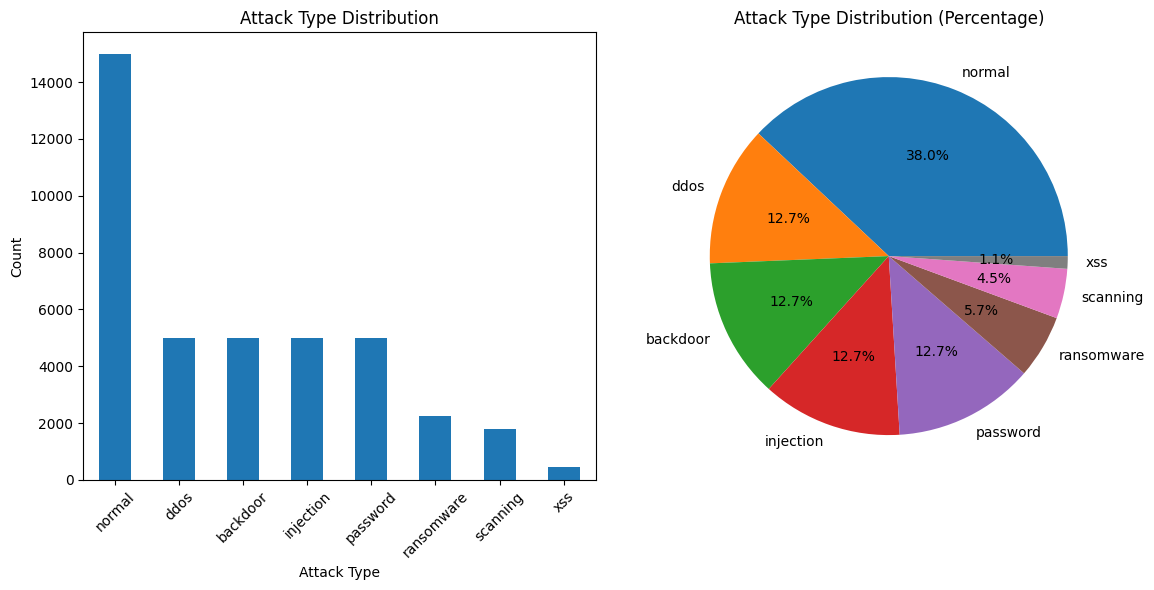

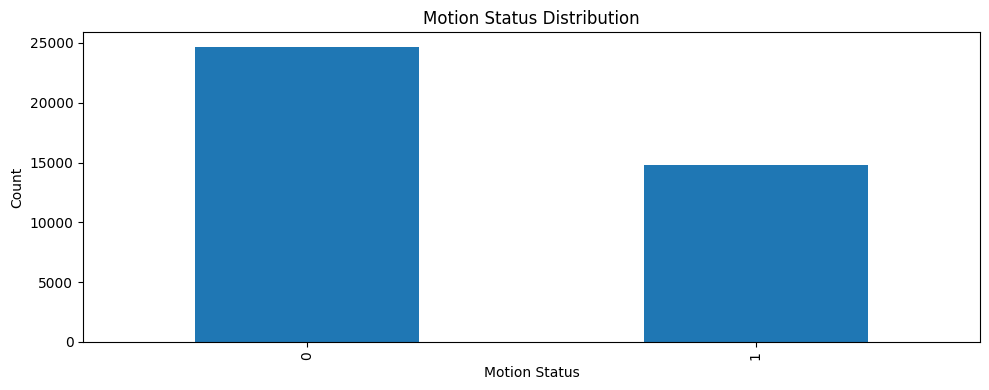

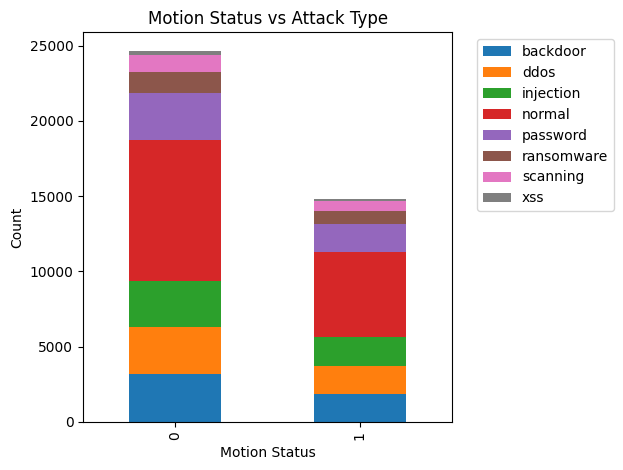

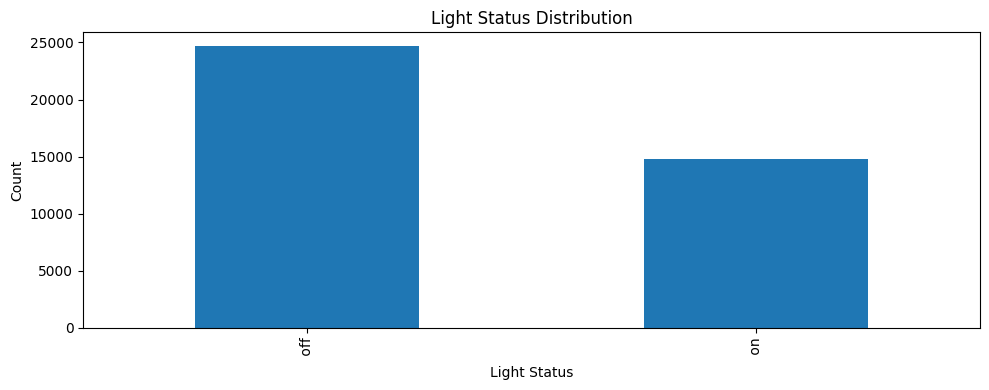

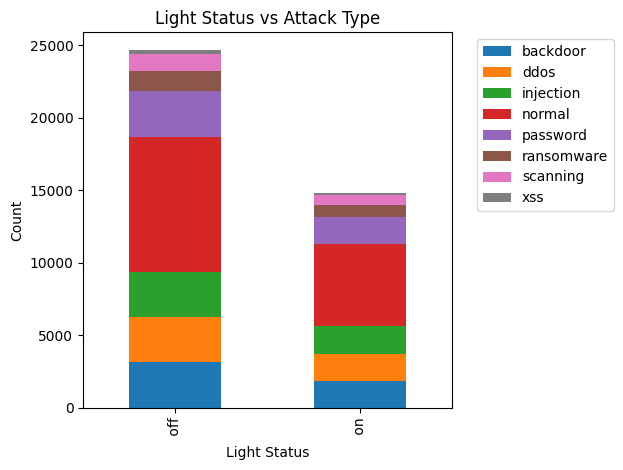

In [3]:
# ================================
# DATA EXPLORATION
# ================================

print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

# Check data types
print("Data Types:")
print(df.dtypes)

# Check unique values in categorical columns
print(f"\nUnique Motion Status: {df['motion_status'].unique()}")
print(f"Unique Motion Light values: {df['light_status'].unique()}")
print(f"Attack type distribution:")
attack_distribution = df['type'].value_counts()
print(attack_distribution)

# Visualize attack type distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['type'].value_counts().plot(kind='bar', rot=45)
plt.title('Attack Type Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Attack Type Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'attack_type_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# Motion Status distribution
plt.figure(figsize=(10, 4))
df['motion_status'].value_counts().plot(kind='bar')
plt.title('Motion Status Distribution')
plt.xlabel('Motion Status')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'motion_status_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

pd.crosstab(df['motion_status'], df['type']).plot(kind='bar', stacked=True)
plt.title('Motion Status vs Attack Type')
plt.xlabel('Motion Status')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'motion_status_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

# Light Status distribution
plt.figure(figsize=(10, 4))
df['light_status'].value_counts().plot(kind='bar')
plt.title('Light Status Distribution')
plt.xlabel('Light Status')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'light_status_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

pd.crosstab(df['light_status'], df['type']).plot(kind='bar', stacked=True)
plt.title('Light Status vs Attack Type')
plt.xlabel('Light Status')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'light_status_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

In [4]:
df_filtered = df.copy()

In [7]:
# ================================
# FEATURE ENGINEERING
# ================================

print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

df_processed = df_filtered.copy()

# Gabung datetime dan ekstrak komponen
df_processed['datetime'] = pd.to_datetime(df_processed['date'].str.strip() + ' ' + df_processed['time'].str.strip(),
                                format='%d-%b-%y %H:%M:%S', errors='coerce')
df_processed = df_processed.sort_values('datetime')
df_processed['hour']        = df_processed['datetime'].dt.hour
df_processed['minute']      = df_processed['datetime'].dt.minute
df_processed['second']      = df_processed['datetime'].dt.second
df_processed['day_of_week'] = df_processed['datetime'].dt.dayofweek
df_processed['is_weekend']  = (df_processed['day_of_week'] >= 5).astype(int)
df_processed['hour_sin']    = np.sin(2*np.pi*df_processed['hour']/24)
df_processed['hour_cos']    = np.cos(2*np.pi*df_processed['hour']/24)
df_processed['min_sin']     = np.sin(2*np.pi*df_processed['minute']/60)
df_processed['min_cos']     = np.cos(2*np.pi*df_processed['minute']/60)

# Encode door state
le = LabelEncoder()
df_processed['light_status'] = le.fit_transform(df_processed['light_status'])

# Time diff
df_processed['time_diff'] = df_processed['datetime'].diff().dt.total_seconds().fillna(0)

# Rolling window stats (window=10)
win = 10
roll_groups = df_processed[['motion_status','light_status']].rolling(window=win, min_periods=1)

df_processed['motion_roll_mean']     = roll_groups['motion_status'].mean()
df_processed['motion_roll_std']      = roll_groups['motion_status'].std().fillna(0)
df_processed['light_roll_mean']    = roll_groups['light_status'].mean()
df_processed['light_roll_std']     = roll_groups['light_status'].std().fillna(0)

# Domain‑spesifik (FFT dominant freq & entropy) — seperti sebelumnya
def dominant_freq(arr, sr=1.0):
    yf = np.abs(rfft(arr))
    xf = rfftfreq(len(arr), d=1/sr)
    idx = np.argmax(yf[1:]) + 1
    return xf[idx]

df_processed['motion_dom_freq'] = (
    df_processed['motion_status']
      .rolling(window=win, min_periods=win)
      .apply(lambda x: dominant_freq(x.values), raw=False)
      .fillna(0)
)

df_processed['light_dom_freq'] = (
    df_processed['light_status']
      .rolling(window=win, min_periods=win)
      .apply(lambda x: dominant_freq(x.values), raw=False)
      .fillna(0)
)

def window_entropy(arr):
    p,_ = np.histogram(arr, bins=10, density=True)
    p = p[p>0]
    return entropy(p)

df_processed['motion_entropy'] = (
    df_processed['motion_status']
      .rolling(window=win, min_periods=win)
      .apply(lambda x: window_entropy(x.values), raw=False)
      .fillna(0)
)

df_processed['light_entropy'] = (
    df_processed['light_status']
      .rolling(window=win, min_periods=win)
      .apply(lambda x: window_entropy(x.values), raw=False)
      .fillna(0)
)

print("Feature engineering extended. Columns:", 
      [c for c in df_processed.columns if c not in df_filtered.columns])


FEATURE ENGINEERING
Feature engineering extended. Columns: ['datetime', 'hour', 'minute', 'second', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos', 'time_diff', 'motion_roll_mean', 'motion_roll_std', 'light_roll_mean', 'light_roll_std', 'motion_dom_freq', 'light_dom_freq', 'motion_entropy', 'light_entropy']


In [8]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39488 entries, 20851 to 5872
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              39488 non-null  object        
 1   time              39488 non-null  object        
 2   motion_status     39488 non-null  int64         
 3   light_status      39488 non-null  int32         
 4   label             39488 non-null  int64         
 5   type              39488 non-null  object        
 6   datetime          39488 non-null  datetime64[ns]
 7   hour              39488 non-null  int32         
 8   minute            39488 non-null  int32         
 9   second            39488 non-null  int32         
 10  day_of_week       39488 non-null  int32         
 11  is_weekend        39488 non-null  int32         
 12  hour_sin          39488 non-null  float64       
 13  hour_cos          39488 non-null  float64       
 14  min_sin           39488 

In [9]:
# ================================
# IDENTIFYING MISSING VALUES
# ================================

print("\n" + "="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)

# Check for missing values
missing_values = df_processed.isnull().sum()
missing_percentage = (missing_values / len(df_processed)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

print("Missing values summary:")
print(missing_df[missing_df['Missing Count'] > 0])

# Visualize missing values if any
if missing_values.sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_processed.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.savefig(os.path.join(viz_dir, 'missing_values_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No missing values found in the dataset!")


MISSING VALUES ANALYSIS
Missing values summary:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []
No missing values found in the dataset!


In [10]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39488 entries, 20851 to 5872
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              39488 non-null  object        
 1   time              39488 non-null  object        
 2   motion_status     39488 non-null  int64         
 3   light_status      39488 non-null  int32         
 4   label             39488 non-null  int64         
 5   type              39488 non-null  object        
 6   datetime          39488 non-null  datetime64[ns]
 7   hour              39488 non-null  int32         
 8   minute            39488 non-null  int32         
 9   second            39488 non-null  int32         
 10  day_of_week       39488 non-null  int32         
 11  is_weekend        39488 non-null  int32         
 12  hour_sin          39488 non-null  float64       
 13  hour_cos          39488 non-null  float64       
 14  min_sin           39488 

In [15]:
# ================================
# SIMPLE IMPUTER AND MINMAX SCALER
# ================================

print("\n" + "="*50)
print("DATA PREPROCESSING - IMPUTATION AND SCALING")
print("="*50)

# Select features for modeling
feature_columns = [
    'is_weekend',
    'hour_sin', 'hour_cos',
    'min_sin', 'min_cos',
    'time_diff',
    'motion_roll_mean', 'motion_roll_std',
    # domain‑spesific
    'light_dom_freq', 'light_entropy'
]

# Prepare features and target
X = df_processed[feature_columns].copy()
y = df_processed['type'].copy()


# Handle any remaining missing values with SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print(f"Features shape after imputation: {X_imputed.shape}")

# Apply MinMax Scaling
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

print("Data scaling completed!")
print(f"Scaled features shape: {X_scaled.shape}")

# Save preprocessors
with open(os.path.join(artifacts_dir, 'imputer.pkl'), 'wb') as f:
    pickle.dump(imputer, f)

with open(os.path.join(artifacts_dir, 'minmax.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

print(f"Imputer saved to {artifacts_dir}/imputer.pkl")
print(f"Scaler saved to {artifacts_dir}/minmax.pkl")

# Encode target labels
label_encoder_target = LabelEncoder()
y_encoded = label_encoder_target.fit_transform(y)

# Save target label encoder
with open(os.path.join(artifacts_dir, 'label_encoder_target.pkl'), 'wb') as f:
    pickle.dump(label_encoder_target, f)

print(f"Target classes: {label_encoder_target.classes_}")
print(f"Target shape: {y_encoded.shape}")
print(f"Target label encoder saved to {artifacts_dir}/label_encoder_target.pkl")


DATA PREPROCESSING - IMPUTATION AND SCALING
Features shape after imputation: (39488, 10)
Data scaling completed!
Scaled features shape: (39488, 10)
Imputer saved to artifacts/imputer.pkl
Scaler saved to artifacts/minmax.pkl
Target classes: ['backdoor' 'ddos' 'injection' 'normal' 'password' 'ransomware' 'scanning'
 'xss']
Target shape: (39488,)
Target label encoder saved to artifacts/label_encoder_target.pkl


In [16]:
print(X_scaled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39488 entries, 0 to 39487
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   is_weekend        39488 non-null  float64
 1   hour_sin          39488 non-null  float64
 2   hour_cos          39488 non-null  float64
 3   min_sin           39488 non-null  float64
 4   min_cos           39488 non-null  float64
 5   time_diff         39488 non-null  float64
 6   motion_roll_mean  39488 non-null  float64
 7   motion_roll_std   39488 non-null  float64
 8   light_dom_freq    39488 non-null  float64
 9   light_entropy     39488 non-null  float64
dtypes: float64(10)
memory usage: 3.0 MB
None



CORRELATION ANALYSIS


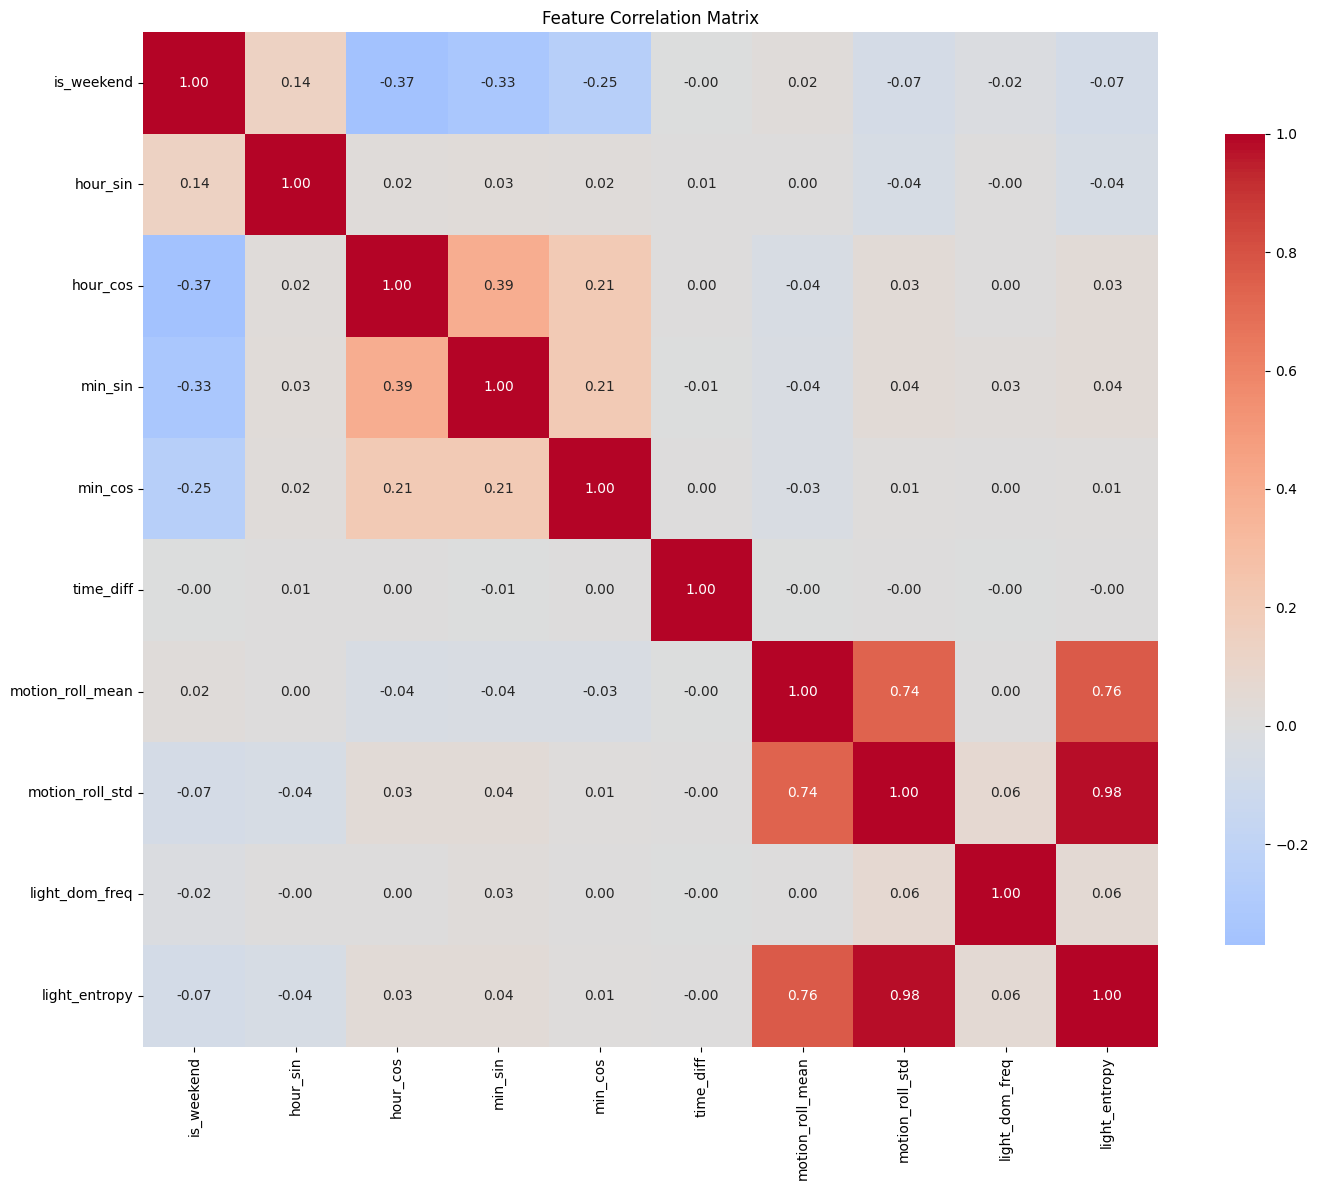

In [17]:
# ================================
# CORRELATION ANALYSIS
# ================================

print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)

# Calculate correlation matrix
correlation_matrix = X_scaled.corr()

# Visualize correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'correlation_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

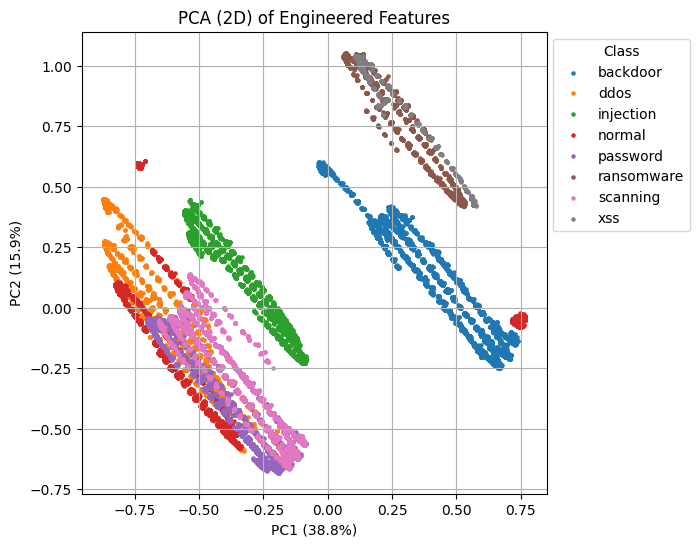

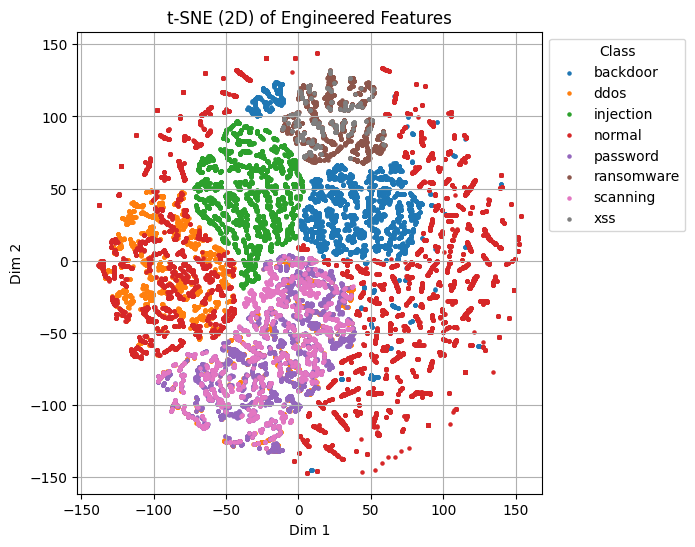

In [18]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,6))
for cls in np.unique(y):
    idx = y == cls
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('PCA (2D) of Engineered Features')
plt.xlabel('PC1 (%.1f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 (%.1f%%)' % (pca.explained_variance_ratio_[1]*100))
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'PCA_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

# 4) t-SNE → 2 dimensi (lebih lambat)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)  # pada seluruh dataset atau subset

plt.figure(figsize=(6,6))
for cls in np.unique(y):
    idx = y == cls
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('t-SNE (2D) of Engineered Features')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'tSNE_2D_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

In [19]:
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_scaled)

# 2) Buat DataFrame untuk Plotly
df_tsne = pd.DataFrame({
    'Dim1': X_tsne_3d[:, 0],
    'Dim2': X_tsne_3d[:, 1],
    'Dim3': X_tsne_3d[:, 2],
    'Class': y.astype(str)
})

# 3) Plot interaktif 3D
fig = px.scatter_3d(
    df_tsne,
    x='Dim1', y='Dim2', z='Dim3',
    color='Class',
    opacity=0.7,
    title='t-SNE (3D) of Engineered Features',
    width=900, height=700
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene = dict(
        xaxis_title='Dim 1',
        yaxis_title='Dim 2',
        zaxis_title='Dim 3'
    ),
    legend_title='Class'
)

# 4) Simpan file HTML ke folder viz_dir
html_path = os.path.join(viz_dir, 'tsne_3d.html')
fig.write_html(html_path)

print(f"File HTML disimpan di: {html_path}")

# PCA ke dalam 3 dimensi
pca = PCA(n_components=3, random_state=42)
X_pca_3d = pca.fit_transform(X_scaled)

# Buat DataFrame dari hasil PCA dan label
df_pca = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca['label'] = y

# Visualisasi interaktif 3D menggunakan Plotly
fig = px.scatter_3d(
    df_pca, x='PC1', y='PC2', z='PC3',
    color='label',
    title='PCA (3D) of Engineered Features',
    labels={'label': 'Class'},
    opacity=0.7,
    width=800,
    height=600
)

# Simpan hasil visualisasi ke file HTML
output_html_path = os.path.join(viz_dir, 'PCA_3D.html')
fig.write_html(output_html_path)

File HTML disimpan di: visualization\tsne_3d.html


In [20]:
with open(os.path.join(artifacts_dir, 'data_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_scaled, y_encoded), f)